In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

og_data = pd.read_csv('f1_data_og.csv')

In [2]:
og_data = og_data.rename(columns = {
    'driver_wins': 'team_wins',
    'constructor_wins': 'driver_wins'
})

og_data.columns

Index(['Unnamed: 0', 'season', 'round', 'date', 'driverId', 'grid', 'statusId',
       'position', 'dob', 'driver_nationality', 'team_name',
       'team_nationality', 'GP_circuit', 'country', 'constructorStandingsId',
       'team_wins', 'driverStandingsId', 'driver_wins', 'driver_age',
       'driver_dnf', 'constructor_dnf', 'driver', 'driver_home', 'team_home',
       'race_winner', 'podium_winner', 'pos_delta', 'driver_dnf_ratio',
       'active_driver', 'active_constructor'],
      dtype='object')

In [3]:
cleaned_df = og_data[['season', 'round','GP_circuit', 'grid','team_name','driver','driver_age', 'driver_wins', 'team_wins', 'pos_delta','driver_dnf_ratio','race_winner', 'podium_winner']]
cleaned_df

,season,round,GP_circuit,grid,team_name,driver,driver_age,driver_wins,team_wins,pos_delta,driver_dnf_ratio,race_winner,podium_winner
0,2009,1,Albert Park Grand Prix Circuit,1,Brawn,Jenson Button,29.0,1,1,0,0.072797,1,1
1,2009,1,Albert Park Grand Prix Circuit,2,Brawn,Rubens Barrichello,37.0,0,1,0,0.089623,0,1
2,2007,1,Albert Park Grand Prix Circuit,14,Honda,Jenson Button,27.0,0,0,0,0.072797,0,0
3,2007,1,Albert Park Grand Prix Circuit,16,Honda,Rubens Barrichello,35.0,0,0,-1,0.089623,0,0
4,2006,3,Albert Park Grand Prix Circuit,1,Honda,Jenson Button,26.0,0,0,0,0.072797,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9557,2021,20,Losail International Circuit,18,Alfa Romeo,Antonio Giovinazzi,28.0,0,0,0,0.081967,0,0
9558,2021,20,Losail International Circuit,19,Haas F1 Team,Mick Schumacher,23.0,0,0,0,0.069767,0,0
9559,2021,20,Losail International Circuit,20,Haas F1 Team,Nikita Mazepin,23.0,0,0,0,0.136364,0,0
9560,2021,20,Losail International Circuit,2,AlphaTauri,Pierre Gasly,26.0,0,0,-2,0.084034,0,0


In [4]:
#V10 Engine Era is the reason for sectioning of more data to the year 2000 and onwards
cleaned_df = cleaned_df[cleaned_df.season >= 2000]

In [5]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

# Step 1: Encode Categorical Features

# one-hot encoding for 'GP_circuit' and 'team_name':
cleaned_df = pd.get_dummies(cleaned_df, columns=['GP_circuit', 'team_name'])

In [6]:
# Step 2: Split the Data
#Train on data from 2000 - 2018
train_data = cleaned_df[(cleaned_df['season'] >= 2000) & (cleaned_df['season'] < 2019)]

#Validate on data from 2019-2022
validation_data = cleaned_df[(cleaned_df['season'] >= 2019) & (cleaned_df['season'] <= 2022)]

#Test on 2023 grand prix using a function we will define after model selection
test_data = cleaned_df[(cleaned_df['season'] == 2023)]

In [7]:
drop_X = ['race_winner', 'podium_winner', 'driver']

X_train = train_data.drop(drop_X, axis=1)  # Features for training
y_train = train_data['podium_winner']  # Target variable for training

X_validate = validation_data.drop(drop_X, axis = 1)
y_validate = validation_data['podium_winner']

X_test = test_data.drop(drop_X, axis=1)  # Features for testing
y_test = test_data['podium_winner']  # Target variable for testing


# Print the shapes of the train and test sets
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)
print("Validation data shape:", X_validate.shape, y_validate.shape)

Training data shape: (6429, 77) (6429,)
Testing data shape: (240, 77) (240,)
Validation data shape: (1637, 77) (1637,)


In [8]:
from sklearn.preprocessing import RobustScaler

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit and transform the scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

X_validate_scaled = scaler.transform(X_validate)

# Transform testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Cross Validation and Hyperparamter Tuning

## Random Forest

In [9]:
from sklearn.model_selection import GridSearchCV

# Random Forest hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [30, 50],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv = 4, n_jobs = -1, scoring='accuracy')
rf_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding accuracy
print("Random Forest - Best Parameters:", rf_grid_search.best_params_)
print("Random Forest - Best Accuracy:", rf_grid_search.best_score_)

# Get the best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

validate_score = best_rf_model.score(X_validate_scaled, y_validate)
print("Random Forest - Validate Accuracy: ", validate_score)

Random Forest - Best Parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest - Best Accuracy: 0.9928446790626828
Random Forest - Validate Accuracy:  0.9835064141722664


## SVM

In [10]:
# SVM hyperparameter tuning
svm_param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}

svm_grid_search = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=4, n_jobs = -1, scoring='accuracy')
svm_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding accuracy
print("SVM - Best Parameters:", svm_grid_search.best_params_)
print("SVM - Best Accuracy:", svm_grid_search.best_score_)

# Get the best SVM model
best_svm_model = svm_grid_search.best_estimator_

validate_score = best_svm_model.score(X_validate_scaled, y_validate)
print("SVM - Validate Accuracy: ", validate_score)


SVM - Best Parameters: {'C': 1, 'kernel': 'linear'}
SVM - Best Accuracy: 1.0
SVM - Validate Accuracy:  1.0


## Logistic Regression

In [11]:
# Logistic Regression hyperparameter tuning
logistic_param_grid = {
    'C': [0.1,1,10,50,100],
    'penalty': ['l2']
}

logistic_grid_search = GridSearchCV(LogisticRegression(max_iter = 3000, random_state=42), logistic_param_grid, cv=4, scoring='accuracy')
logistic_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding accuracy
print("Logistic Regression - Best Parameters:", logistic_grid_search.best_params_)
print("Logistic Regression - Best Accuracy:", logistic_grid_search.best_score_)

# Get the best Logistic Regression model
best_logistic_model = logistic_grid_search.best_estimator_

LR_validate_score = best_logistic_model.score(X_validate_scaled, y_validate)
print("LogReg - Validate Accuracy: ", LR_validate_score)

Logistic Regression - Best Parameters: {'C': 50, 'penalty': 'l2'}
Logistic Regression - Best Accuracy: 1.0
LogReg - Validate Accuracy:  1.0


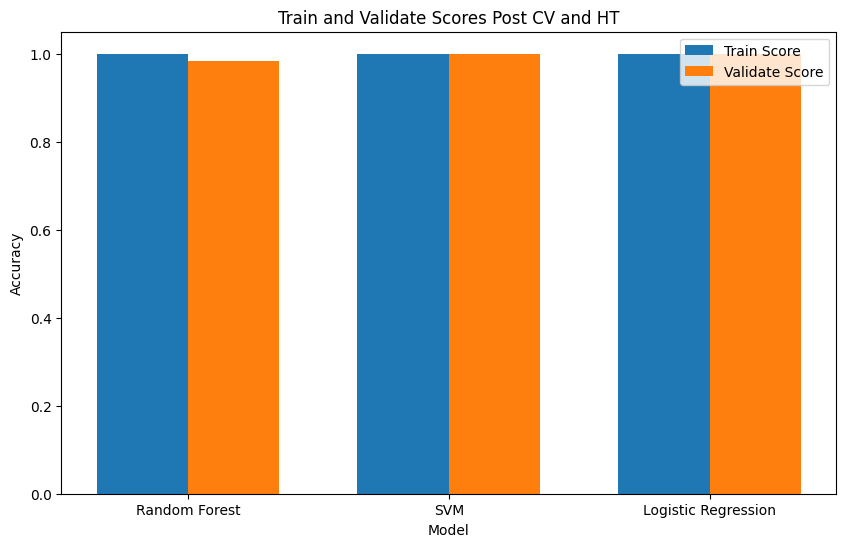

In [12]:
import numpy as np
# Create lists for train and Validate scores

#Train scores
rf_train_score = best_rf_model.score(X_train_scaled,y_train)
SVM_train_score = best_svm_model.score(X_train_scaled, y_train)
LR_train_score = logistic_grid_search.best_score_

#Validate scores
rf_val_score = best_rf_model.score(X_validate_scaled,y_validate)
SVM_val_score = best_svm_model.score(X_validate_scaled,y_validate)
LR_val_score = LR_validate_score

train_scores = [rf_train_score, SVM_train_score, LR_train_score]
validate_scores = [rf_val_score, SVM_val_score, LR_val_score]

# Create a list of model names
model_names = ['Random Forest','SVM','Logistic Regression']

# Plot train and test scores
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(model_names))

plt.bar(index, train_scores, bar_width, label='Train Score')
plt.bar(index + bar_width, validate_scores, bar_width, label='Validate Score')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Train and Validate Scores Post CV and HT')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.show()